# Significant Earthquakes since 2150 BC

This dataset is from NOAA's Significant Earthquake Database, extracted on October 16.

[Here's a link to their page](https://www.ngdc.noaa.gov/nndc/struts/results?bt_0=&st_0=&type_17=EXACT&query_17=None+Selected&op_12=eq&v_12=&type_12=Or&query_14=None+Selected&type_3=Like&query_3=&st_1=&bt_2=&st_2=&bt_1=&bt_4=&st_4=&bt_5=&st_5=&bt_6=&st_6=&bt_7=&st_7=&bt_8=&st_8=&bt_9=&st_9=&bt_10=&st_10=&type_11=Exact&query_11=&type_16=Exact&query_16=&bt_18=&st_18=&ge_19=&le_19=&type_20=Like&query_20=&display_look=1&t=101650&s=1&submit_all=Search+Database)

Here's a preview I made using the dataset.

![Thumbnail](earthquakes.png "Significant Earthquakes")

My goal here was to demonstrate some of the things you can do with Jupyter Notebook, Pandas, and BeautifulSoup by scraping data from a web page and save it into a more useable CSV format.

Here's a link to the raw CSV data: https://raw.githubusercontent.com/benjiao/significant-earthquakes/master/earthquakes.csv

In [1]:
%matplotlib inline

import requests

### Fetch data

In [2]:
response = requests.get("https://www.ngdc.noaa.gov/nndc/struts/results?bt_0=&st_0=&type_17=EXACT&query_17=None+Selected&op_12=eq&v_12=&type_12=Or&query_14=None+Selected&type_3=Like&query_3=&st_1=&bt_2=&st_2=&bt_1=&bt_4=&st_4=&bt_5=&st_5=&bt_6=&st_6=&bt_7=&st_7=&bt_8=&st_8=&bt_9=&st_9=&bt_10=&st_10=&type_11=Exact&query_11=&type_16=Exact&query_16=&bt_18=&st_18=&ge_19=&le_19=&type_20=Like&query_20=&display_look=1&t=101650&s=1&submit_all=Search+Database")

### Parse response

Here we use beautiful soup to read the HTML response.

In [3]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

Upon inspection of the the page, there are 3 tables. The third one is the one that contains the data we need. The rest were being used for the page layout.

In [4]:
tables = soup.find_all('table')
all_rows = tables[2].find_all('tr')
len(all_rows)

5966

The first 2 rows contain headers...

In [5]:
rows = all_rows[3:]
len(rows)

5963

### Build JSON data

To keep things clean and reusable, we build a function for mapping columns into a Python dictionary object.

We also use Shapely to format coordinates into WKT Points


In [6]:
from shapely.geometry import Point
from shapely.wkt import dumps

def parse_row(data):
    columns = data.find_all("td")
    
    
    try:
        location = dumps(Point(float(columns[11].string.strip()), float(columns[10].string.strip())))
    except (AttributeError, ValueError):
        location = None
    except:
        print("Year: {}, {} {}".format(columns[0].string.strip(), columns[10].string, columns[11].string))
        
    return {
        "year": int(columns[0].string.strip()) if columns[0].string is not None else None,
        "month": int(columns[1].string.strip()) if columns[1].string is not None else None,
        "day": int(columns[2].string.strip()) if columns[2].string is not None else None,
        "hour": int(columns[3].string.strip()) if columns[3].string is not None else None,
        "minute": int(columns[4].string.strip()) if columns[4].string is not None else None,
        "second": columns[5].string.strip() if columns[5].string is not None else None,
        "name": columns[9].string.strip() if columns[9].string is not None else None,
        "location": location,
        "focal_depth": columns[12].string.strip() if columns[12].string is not None else None,
        "magnitude": columns[13].string.strip() if columns[13].string is not None else None,
        "mmi_int": columns[14].string.strip() if columns[14].string is not None else None, # Modified Mercalli Intensity (MMI)
        "deaths": columns[15].string.strip() if columns[15].string is not None else None,
        "damage": columns[17].string.strip() if columns[17].string is not None else None, # In million $
        "houses_destroyed": columns[19].string.strip() if columns[19].string is not None else None, # In million $
        "houses_damaged": columns[21].string.strip() if columns[21].string is not None else None, # In million $
    }

parse_row(rows[5962])

{'damage': '11',
 'day': 23,
 'deaths': None,
 'focal_depth': '31',
 'hour': 20,
 'houses_damaged': None,
 'houses_destroyed': None,
 'location': 'POINT (124.8739999999999952 7.6289999999999996)',
 'magnitude': '5.7',
 'minute': 47,
 'mmi_int': None,
 'month': 9,
 'name': 'PHILIPPINES: MINDANAO: LANAO DEL SUR PROVINCE',
 'second': '8.0',
 'year': 2017}

Run the parser on all rows...

In [7]:
rows_dict = [parse_row(row) for row in rows]

### Read data using Pandas

This will allow us to check basic stats on our data

In [8]:
import pandas

In [9]:
earthquakes_df = pandas.DataFrame.from_dict(rows_dict)
earthquakes_df.head()

,damage,day,deaths,focal_depth,hour,houses_damaged,houses_destroyed,location,magnitude,minute,mmi_int,month,name,second,year
0,None,NaN,None,None,NaN,None,None,POINT (35.5000000000000000 31.1000000000000014),7.3,NaN,None,NaN,"JORDAN: BAB-A-DARAA,AL-KARAK",,-2150
1,None,NaN,None,None,NaN,None,None,POINT (35.7999999999999972 35.6829999999999998),None,NaN,10,NaN,SYRIA: UGARIT,None,-2000
2,None,NaN,1,18,NaN,None,None,POINT (58.2000000000000028 38.0000000000000000),7.1,NaN,10,NaN,TURKMENISTAN: W,None,-2000
3,None,NaN,None,None,NaN,None,None,POINT (25.3999999999999986 36.3999999999999986),None,NaN,None,NaN,GREECE: THERA ISLAND (SANTORINI),None,-1610
4,None,NaN,None,None,NaN,None,None,POINT (35.2999999999999972 31.5000000000000000),None,NaN,10,NaN,ISRAEL: ARIHA (JERICHO),,-1566


In [10]:
earthquakes_df.describe()

,day,hour,minute,month,year
count,5407.000000,3936.000000,3731.000000,5558.000000,5963.000000
mean,15.750139,11.301067,28.777272,6.505218,1798.479624
std,8.750386,7.030054,17.146287,3.448569,380.277202
min,1.000000,0.000000,0.000000,1.000000,-2150.000000
25%,8.000000,5.000000,14.000000,4.000000,1812.000000
50%,16.000000,11.000000,29.000000,7.000000,1925.000000
75%,23.000000,17.000000,43.000000,9.000000,1984.000000
max,31.000000,23.000000,59.000000,12.000000,2017.000000


From this, we can tell that out of 5963 data points, only 5558 have values for month, 5407 have values for day, and 3936 for hour.

We can also take a peak at the distribution of our data by year using pandas' built in integration with Matplotlib:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafa38f5128>]], dtype=object)

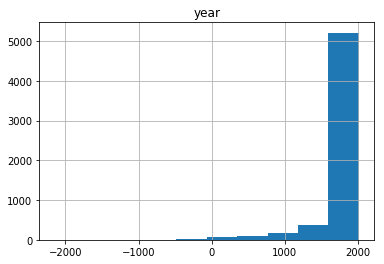

In [11]:
earthquakes_df.hist(column="year")

### Check usable rows

Some rows might not have entries for specific columns such as month, day, or even location. Let's take a look at this:

Right away, we can tell that all items after 1932 have month data because 1932 was the last year where we encountered a null month value:

In [12]:
earthquakes_df[earthquakes_df["month"].isnull()]["year"].max()

1932

All entries after 1957 have complete values for day:

In [13]:
earthquakes_df[earthquakes_df["day"].isnull()]["year"].max()

1957

All rows after 1977 have data for hour:

In [14]:
earthquakes_df[earthquakes_df["hour"].isnull()]["year"].max()

1977

The rest are pretty self expalatory...

In [15]:
earthquakes_df[earthquakes_df["minute"].isnull()]["year"].max()

1992

In [16]:
earthquakes_df[earthquakes_df["second"].isnull()]["year"].max()

1992

In [17]:
earthquakes_df[earthquakes_df["location"].isnull()]["year"].max()

1978

### Save data into CSV

In [18]:
earthquakes_df.to_csv('earthquakes.csv')